In [28]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd

In [54]:
nwp_path = "gs://solar-pv-nowcasting-data/NWP/UK_Met_Office/UKV_intermediate_version_3.zarr/"
gsp_path = "gs://solar-pv-nowcasting-data/PV/GSP/v5/pv_gsp.zarr"
gsp = xr.open_zarr(gsp_path)
nwp = xr.open_zarr(nwp_path)

In [55]:
evaluation_timeseries = gsp.coords["datetime_gmt"].where(
        (gsp["datetime_gmt"] >= nwp.coords["init_time"].values[0]) & (gsp["datetime_gmt"] <= nwp.coords["init_time"].values[-1]), 
        drop=True).values

gsp = gsp.sel(datetime_gmt = evaluation_timeseries, gsp_id=0)

In [91]:
# stolen from datapipes

from pandas.core.dtypes.common import is_datetime64_dtype
import numpy.typing as npt
from typing import Union, Tuple


TRIG_DATETIME_FEATURE_NAMES = ["SIN_MONTH", "COS_MONTH", "SIN_DAY", "COS_DAY", "SIN_HOUR", "COS_HOUR"]


def _trig_transform(values: np.ndarray, period: Union[float, int]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Given a list of values and an upper limit on the values, compute trig decomposition.
    Args:
        values: ndarray of points in the range [0, period]
        period: period of the data
    Returns:
        Decomposition of values into sine and cosine of data with given period
    """

    return np.sin(values * 2 * np.pi / period), np.cos(values * 2 * np.pi / period)


def trigonometric_datetime_transformation(datetimes: npt.ArrayLike) -> np.ndarray:
    """
    Given an iterable of datetimes, returns a trigonometric decomposition on hour, day and month
    Args:
        datetimes: ArrayLike of datetime64 values
    Returns:
        Trigonometric decomposition of datetime into hourly, daily and
        monthly values.
    """
    assert is_datetime64_dtype(datetimes), "Data for Trig Decomposition must be np.datetime64 type"

    datetimes = pd.DatetimeIndex(datetimes)
    hour = datetimes.hour.values.reshape(-1, 1) + (datetimes.minute.values.reshape(-1, 1) / 60)
    day = datetimes.day.values.reshape(-1, 1)
    month = datetimes.month.values.reshape(-1, 1)

    sine_hour, cosine_hour = _trig_transform(hour, 24)
    sine_day, cosine_day = _trig_transform(day, 366)
    sine_month, cosine_month = _trig_transform(month, 12)

    return np.concatenate(
        [sine_month, cosine_month, sine_day, cosine_day, sine_hour, cosine_hour], axis=1
    )


def build_datasets_from_local(step: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    X = np.load(f"/home/tom/local_data/basic_processed_nwp_data_step_{step}.npy")
    X = pd.DataFrame(data=X.reshape(X.shape[1], X.shape[2]).T, columns=nwp.coords["variable"], index=evaluation_timeseries)
    y = pd.DataFrame(gsp["generation_mw"] / gsp["installedcapacity_mwp"], index=evaluation_timeseries, columns=["target"])
    
    # shift y by the step forecast
    shift = nwp.step.values[step]
    y = y.shift(freq=-shift).dropna()
    common_index=sorted(pd.DatetimeIndex((set(y.index).intersection(X.index))))
    
    X, y = X.loc[common_index], y.loc[common_index]
    
    # add datetime methods for the point at which we are forecasting e.g. now + step
    _X = trigonometric_datetime_transformation(y.shift(freq=nwp.step.values[step]).index.values)
    _X = pd.DataFrame(_X, index=y.index, columns=TRIG_DATETIME_FEATURE_NAMES)
    X = pd.concat([X, _X], axis=1)
    
    return X, y

In [179]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from dataclasses import dataclass

DEFFAULT_HYPARAM_CONFIG = {
               'objective': 'reg:squarederror',
               'booster': 'gbtree',
               'colsample_bylevel': 1,
               'colsample_bynode': 1,
               'colsample_bytree': 0.85,
               'early_stopping_rounds': None,
               'gamma': 0,
               'gpu_id': -1,
               'grow_policy': 'depthwise',
               'importance_type': None,
               'interaction_constraints': '',
               'learning_rate': 0.01,
               'max_bin': 256,
               'max_cat_threshold': 64,
               'max_depth': 50,
               'max_leaves': 0,
               'min_child_weight': 20,
               'n_estimators': 1500,
               'n_jobs': -1,
               'num_parallel_tree': 1,
               'predictor': 'auto',
               'random_state': 0,
               'reg_alpha': 0,
               'reg_lambda': 1,
               'sampling_method': 'uniform',
               'scale_pos_weight': 1,
               'subsample': 0.85,
               'tree_method': 'hist',
               'validate_parameters': 1,
               'verbosity': 1
 }


@dataclass
class ExperimentSummary:
    mse_train_loss_mean: float
    mse_train_loss_std: float
    mse_test_loss_mean: float
    mse_test_loss_std: float
    mae_train_loss_mean: float
    mae_train_loss_std: float
    mae_test_loss_mean: float
    mae_test_loss_std: float
    model: XGBRegressor



def run_experiment(X: pd.DataFrame,
                   y: pd.DataFrame,
                   number_of_runs: int = 1,
                   train_test_split_fraction: float = 0.8,
                   booster_hyperparam_config: dict = DEFFAULT_HYPARAM_CONFIG,
                   randomised_splitting: bool = False) -> ExperimentSummary:
    
    
    train_mse, train_mae, test_mse, test_mae = np.empty((4, number_of_runs))
    
    for run in range(number_of_runs):
        if randomised_splitting:
            # start with a randomised train/test split before structing a time-series specific one
            n = X.shape[0]
            train_idx = np.random.choice(np.arange(n), int(train_test_split_fraction*n), replace=False)
            test_idx = list(set(np.arange(n)).difference(train_idx))
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        else:
            # use 2020 as training period and 2021 as test
            X_train, y_train = X.loc[X.index < "2021-01-01"], y.loc[y.index < "2021-01-01"]
            X_test, y_test = X.loc[X.index >= "2021-01-01"], y.loc[y.index >= "2021-01-01"]
        
        model = XGBRegressor(**booster_hyperparam_config)
        model.fit(X_train, y_train)
        
        y_pred_test, y_pred_train = model.predict(X_test), model.predict(X_train)
        train_mse[run], test_mse[run] = mean_squared_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred_test)
        train_mae[run], test_mae[run] = mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_test, y_pred_test)
        
    
    return ExperimentSummary(
        np.mean(train_mse),
        np.std(train_mse),
        np.mean(test_mse),
        np.std(test_mse),
        np.mean(train_mae),
        np.std(train_mae),
        np.mean(test_mae),
        np.std(test_mae),
        model  # just save the last trained model for nwo
    )
        

In [178]:
X.loc[X.index < "2021-01-01"]

,cdcb,lcc,mcc,hcc,sde,hcct,dswrf,dlwrf,h,t,...,si10,wdir10,prmsl,prate,SIN_MONTH,COS_MONTH,SIN_DAY,COS_DAY,SIN_HOUR,COS_HOUR
2020-01-01 00:00:00,521.120361,84.835526,38.221878,64.858032,0.001249,-25614.957031,48.600773,341.990997,2315.551758,281.955383,...,11.917580,212.825974,100853.390625,0.000064,0.5,0.866025,0.034328,0.999411,2.588190e-01,-0.965926
2020-01-01 00:30:00,553.361536,84.210251,40.360672,64.199261,0.001249,-24879.376152,52.167124,341.663762,2285.289255,281.974727,...,11.912142,213.455232,100788.447713,0.000070,0.5,0.866025,0.034328,0.999411,1.305262e-01,-0.991445
2020-01-01 01:00:00,579.262635,83.691035,42.163818,63.412333,0.001248,-24490.632791,52.957390,341.301595,2253.661698,281.987899,...,11.899043,214.494350,100732.050919,0.000074,0.5,0.866025,0.034328,0.999411,1.224647e-16,-1.000000
2020-01-01 01:30:00,599.487447,83.257223,43.679141,62.496586,0.001247,-24393.150124,51.389006,340.905164,2220.861752,281.995323,...,11.879952,215.891229,100683.719232,0.000077,0.5,0.866025,0.034328,0.999411,-1.305262e-01,-0.991445
2020-01-01 02:00:00,614.699763,82.888159,44.954463,61.451358,0.001246,-24531.351328,47.879408,340.475137,2187.082084,281.997421,...,11.856539,217.593770,100642.971638,0.000079,0.5,0.866025,0.034328,0.999411,-2.588190e-01,-0.965926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 21:30:00,841.043357,51.673844,40.840184,2.758004,0.005559,-9689.353018,15.386456,289.568582,655.048924,277.628019,...,5.495699,205.145645,101891.244657,0.000020,0.5,0.866025,0.034328,0.999411,7.933533e-01,-0.608761
2020-12-31 22:00:00,867.153790,51.446952,41.349230,2.932488,0.005567,-9870.576206,32.411976,289.877278,656.032985,277.713489,...,5.456294,204.018089,101907.037804,0.000020,0.5,0.866025,0.034328,0.999411,7.071068e-01,-0.707107
2020-12-31 22:30:00,895.382872,51.191291,41.836950,3.093927,0.005576,-10011.703072,51.293651,290.152884,656.567821,277.812089,...,5.414470,203.183501,101919.363817,0.000019,0.5,0.866025,0.034328,0.999411,6.087614e-01,-0.793353
2020-12-31 23:00:00,922.735788,50.934716,42.268914,3.229289,0.005584,-10068.341343,70.041870,290.398194,656.736294,277.918949,...,5.375059,202.557628,101928.644572,0.000019,0.5,0.866025,0.034328,0.999411,5.000000e-01,-0.866025


In [124]:
results = dict()

for step in range(0, 36):
    # can't really multiprocess this, the xgb training maxes out the cores anyway
    X, y = build_datasets_from_local(step)
    output = run_experiment(X, y, 5, 0.8)
    results[step] = output
    print(f"Completed run for step {step}")

Completed run for step 0
Completed run for step 1
Completed run for step 2
Completed run for step 3
Completed run for step 4
Completed run for step 5
Completed run for step 6
Completed run for step 7
Completed run for step 8
Completed run for step 9
Completed run for step 10
Completed run for step 11
Completed run for step 12
Completed run for step 13
Completed run for step 14
Completed run for step 15
Completed run for step 16
Completed run for step 17
Completed run for step 18
Completed run for step 19
Completed run for step 20
Completed run for step 21
Completed run for step 22
Completed run for step 23
Completed run for step 24
Completed run for step 25
Completed run for step 26
Completed run for step 27
Completed run for step 28
Completed run for step 29
Completed run for step 30
Completed run for step 31
Completed run for step 32
Completed run for step 33
Completed run for step 34
Completed run for step 35


In [164]:
import pickle

# with open('/home/tom/local_data/xgb_forecast_steps_v1.pkl', 'wb') as f:
#     pickle.dump(results, f)

# with open('/home/tom/local_data/xgb_forecast_steps_v1.pkl', 'rb') as f:
#     results = pickle.load(f)

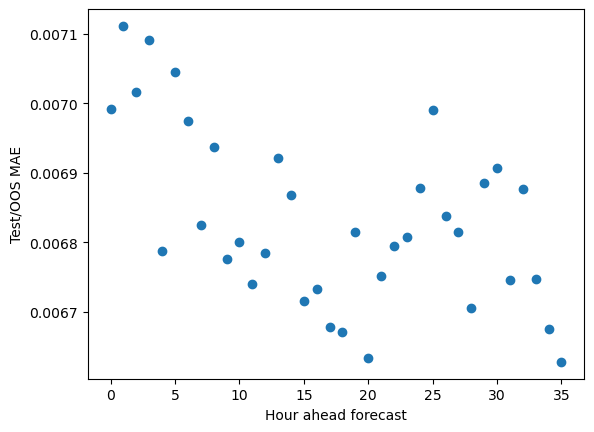

In [161]:
mae_test = pd.Series({step: r.mae_test_loss_mean for step, r in results.items()})
plt.scatter(mae_test.index, mae_test.values)
plt.ylabel("Test/OOS MAE")
plt.xlabel("Hour ahead forecast")
plt.show()

<AxesSubplot: >

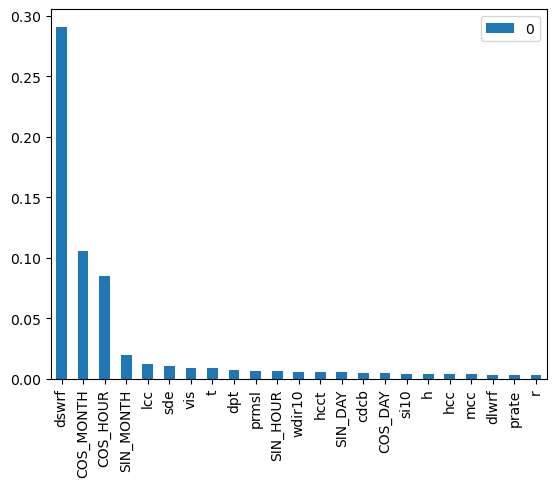

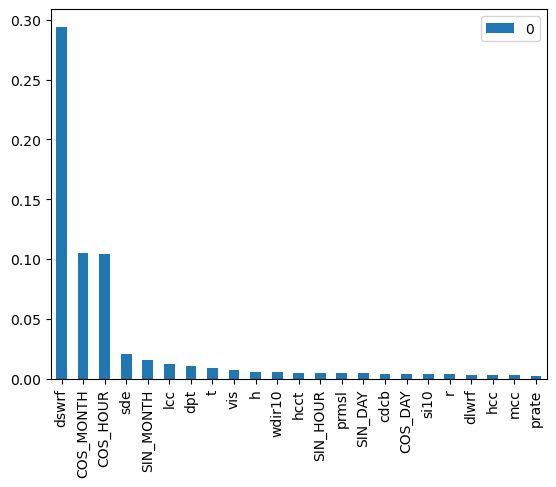

In [157]:
pd.DataFrame.from_dict(results[30].model.get_booster().get_score(importance_type='gain'), orient="index").sort_values(by=0, ascending=False).plot.bar()
pd.DataFrame.from_dict(results[1].model.get_booster().get_score(importance_type='gain'), orient="index").sort_values(by=0, ascending=False).plot.bar()

<AxesSubplot: >

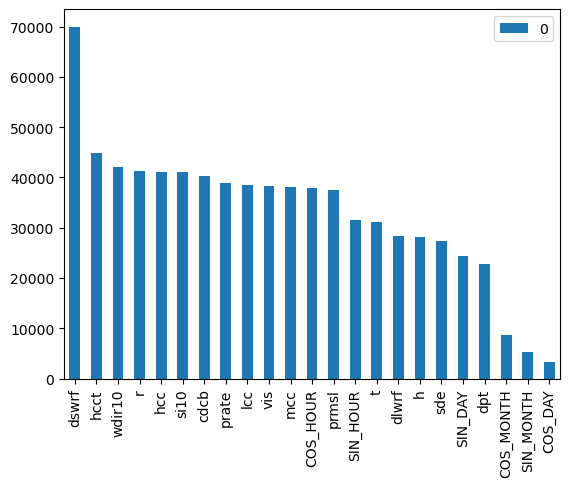

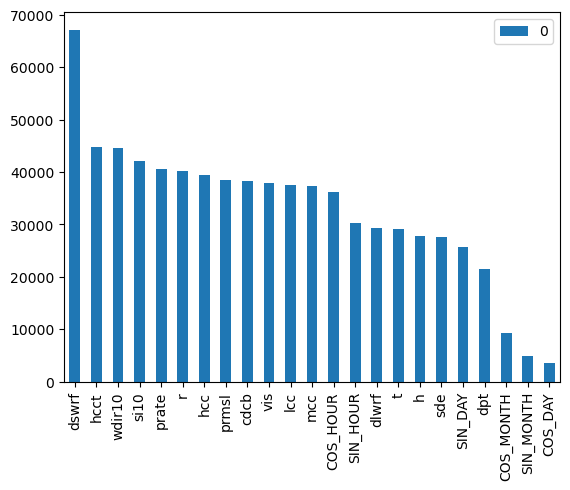

In [158]:
pd.DataFrame.from_dict(results[30].model.get_booster().get_score(importance_type='weight'), orient="index").sort_values(by=0, ascending=False).plot.bar()
pd.DataFrame.from_dict(results[1].model.get_booster().get_score(importance_type='weight'), orient="index").sort_values(by=0, ascending=False).plot.bar()

<AxesSubplot: >

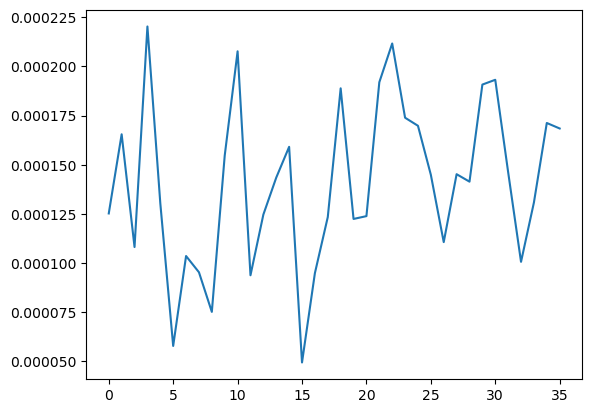

In [135]:
pd.Series({step: r.mae_test_loss_std for step, r in results.items()}).plot()

<AxesSubplot: >

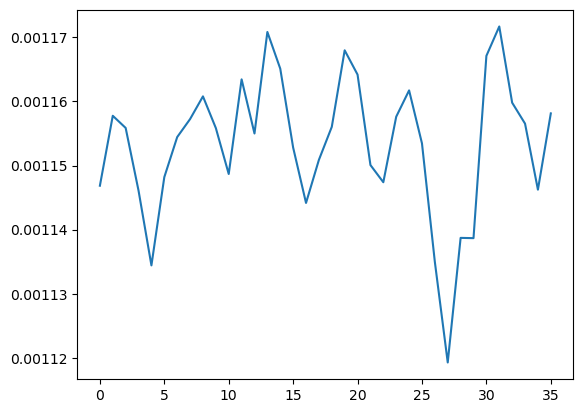

In [134]:
pd.Series({step: r.mae_train_loss_mean for step, r in results.items()}).plot()

In [166]:
_model = results[0].model

In [170]:
temp = dict()

for step in range(36):
    X, y = build_datasets_from_local(step)
    y_pred = _model.predict(X)
    temp[step] = mean_absolute_error(y, y_pred)
    

<AxesSubplot: >

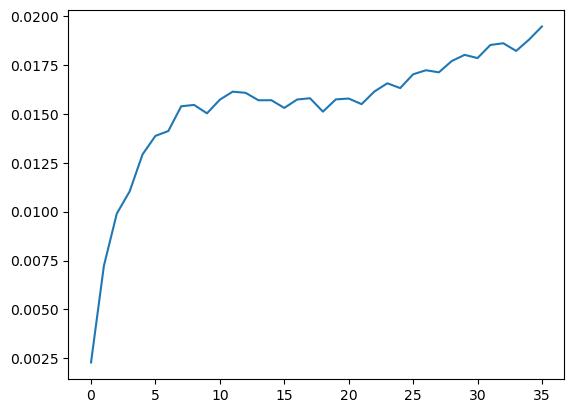

In [171]:
pd.Series(temp).plot()

In [176]:
X.index[X.index < "2021-01-01"]

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 00:30:00',
               '2020-01-01 01:00:00', '2020-01-01 01:30:00',
               '2020-01-01 02:00:00', '2020-01-01 02:30:00',
               '2020-01-01 03:00:00', '2020-01-01 03:30:00',
               '2020-01-01 04:00:00', '2020-01-01 04:30:00',
               ...
               '2020-12-31 19:00:00', '2020-12-31 19:30:00',
               '2020-12-31 20:00:00', '2020-12-31 20:30:00',
               '2020-12-31 21:00:00', '2020-12-31 21:30:00',
               '2020-12-31 22:00:00', '2020-12-31 22:30:00',
               '2020-12-31 23:00:00', '2020-12-31 23:30:00'],
              dtype='datetime64[ns]', length=17568, freq=None)